In [1]:
# step 1, install rubin_sim:  https://github.com/lsst/rubin_sim

In [2]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import rubin_sim.maf as maf
import healpy as hp
from rubin_sim.data import get_baseline

In [3]:
# Need a database to work on. You can grab this one from: 
# http://astro-lsst-01.astro.washington.edu:8080/fbs_db/fbs_2.99/draft/draft_connected_v2.99_10yrs.db

# all the columns in the database documented at: https://rubin-sim.lsst.io/rs_scheduler/output_schema.html

# or just use the baseline that comes with rubin_sim
filename = get_baseline()
run_name = filename.replace('.db', '')


In [4]:
# Let's make a metric that computes the coadded depth in all filters, applies dust extinction
# Based on the ExgalM5 metric 
from rubin_sim.phot_utils import DustValues

class ExgalCoadding(maf.BaseMetric):
    """
    Calculate co-added five-sigma limiting depth after dust extinction in each filter.

    Uses photUtils to calculate dust extinction.

    Parameters
    ----------
    m5Col : `str`, optional
        Column name for five sigma depth. Default 'fiveSigmaDepth'.
    unit : `str`, optional
        Label for units. Default 'mag'.
    """

    def __init__(
        self,
        m5_col="fiveSigmaDepth",
        metric_name="ExgalM5",
        units="mag",
        filter_col="filter",
        filters='ugrizy',
        **kwargs
    ):
        # Set the name for the dust map to use.
        maps = ["DustMap"]
        self.m5_col = m5_col
        self.filter_col = filter_col
        super().__init__(
            col=[self.m5_col, self.filter_col],
            maps=maps,
            metric_name=metric_name,
            units=units,
            **kwargs
        )
        # Set the default wavelength limits for the lsst filters. These are approximately correct.
        dust_properties = DustValues()
        self.ax1 = dust_properties.ax1
        # We will call Coaddm5Metric to calculate the coadded depth. Set it up here.
        self.Coaddm5Metric = maf.Coaddm5Metric(m5_col=m5_col)
        
        self.filters = filters

    def run(self, data_slice, slice_point):
        """
        Compute the co-added m5 depth and then apply dust extinction to that magnitude.
        """
        # Dict to hold depth in each filter
        depths = {}
        for filtername in self.filters:
            depths[filtername] = self.badval
            
        ufilters = np.unique(data_slice[self.filter_col])
        
        for filtername in ufilters:
            in_filter =np.where(data_slice[self.filter_col] == filtername)
            m5 = self.Coaddm5Metric.run(data_slice[in_filter])
            if m5 == self.Coaddm5Metric.badval:
                depths[filtername] = self.badval
            else:
                # Total dust extinction along this line of sight. Correct default A to this EBV value.
                a_x = self.ax1[filtername] * slice_point["ebv"]
                depths[filtername] = m5 - a_x
                
        # Now here would be a good place to insert something that does some
        # more calculations with these depths!
        
        # Maybe something like call a function that takes 6 coadded depths and
        # returns an uncertainty on photometric redshift. 

        
        # this is returning a dictionary with filternames as keys
        return depths
    
    # For now, let's make reduce methods for two filters
    # Hopefully you can make the returned results above just a float, then you 
    # can delete these reduce functions.
    def reduce_u(self, metric_value):
        return metric_value['u']
    
    def reduce_r(self, metric_value):
        return metric_value['r']
    
    

In [5]:
# Iterate over the whole sky. set useCache=False because we care about dust.
# nside=16 for speed. 
slicer = maf.HealpixSlicer(nside=16, use_cache=False)
metric = ExgalCoadding()
# Select all visits. Here is where you could do "filter='i'" or "night < 365"
sql = ''

bundle_list = [maf.MetricBundle(metric, slicer, sql, run_name=run_name)]
bundle_dict = maf.make_bundles_dict_from_list(bundle_list)


Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


In [6]:
bg = maf.MetricBundleGroup(bundle_dict, filename, out_dir='temp',results_db=None)

/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/maps/dust_map.py:42: UserWarning: Slicer value of nside 16 different from map value 128, using slicer value
  warnings.warn(
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/plots/plot_handler.py:587: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn(
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/utils/maf_utils.py:148: UserWarning: Optimal bin calculation tried to make 428 bins, returning 200
  warnings.warn(
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/utils/maf_utils.py:148: UserWarning: Optimal bin calculation tried to make 701 bins, returning 200
  warnings.warn(


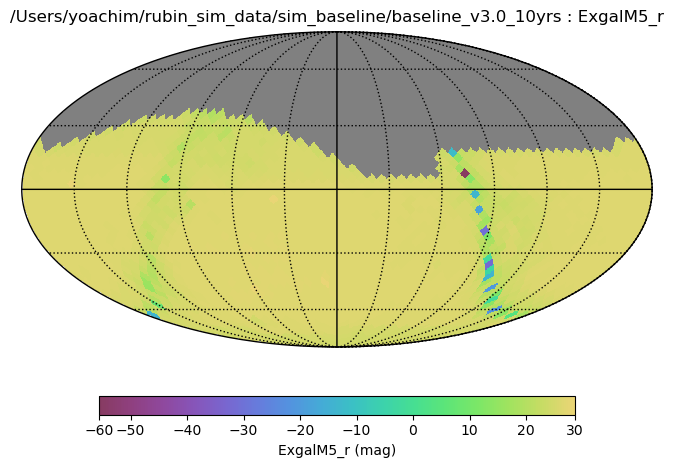

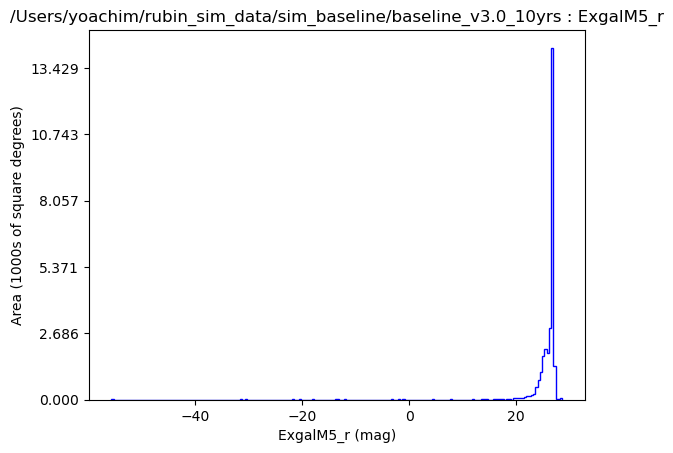

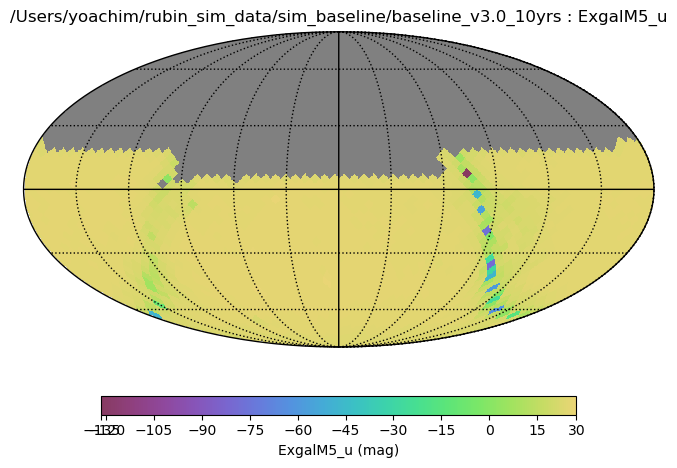

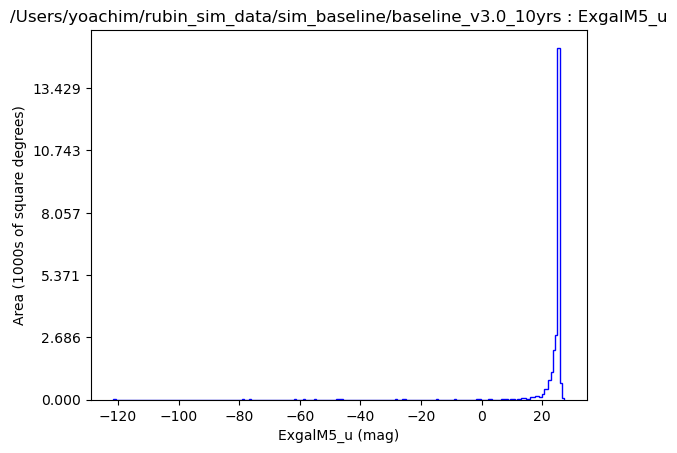

In [7]:
bg.run_all()
bg.plot_all(closefigs=False)

In [8]:
# Wow, the auto generated plots look bad because the extinction values are extreme


In [9]:
# Note our bundle_dict has now expanded. Each reduce function added a new bundle, so we can look at them manually
bundle_dict

{'_Users_yoachim_rubin_sim_data_sim_baseline_baseline_v3_0_10yrs_ExgalM5_HEAL': <rubin_sim.maf.metric_bundles.metric_bundle.MetricBundle at 0x7fa63aa5ddc0>,
 'ExgalM5_r': <rubin_sim.maf.metric_bundles.metric_bundle.MetricBundle at 0x7fa631b30700>,
 'ExgalM5_u': <rubin_sim.maf.metric_bundles.metric_bundle.MetricBundle at 0x7fa63aaec790>}

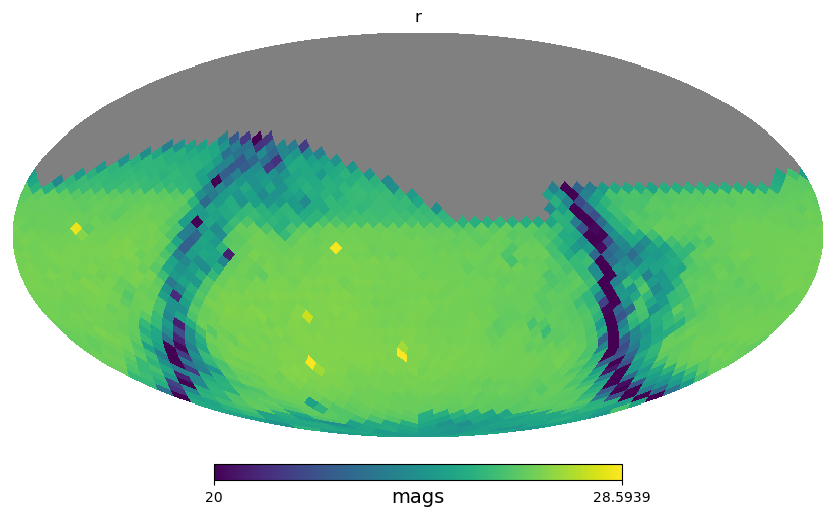

In [10]:
hp.mollview(bundle_dict['ExgalM5_r'].metric_values, min=20, title='r', unit='mags')

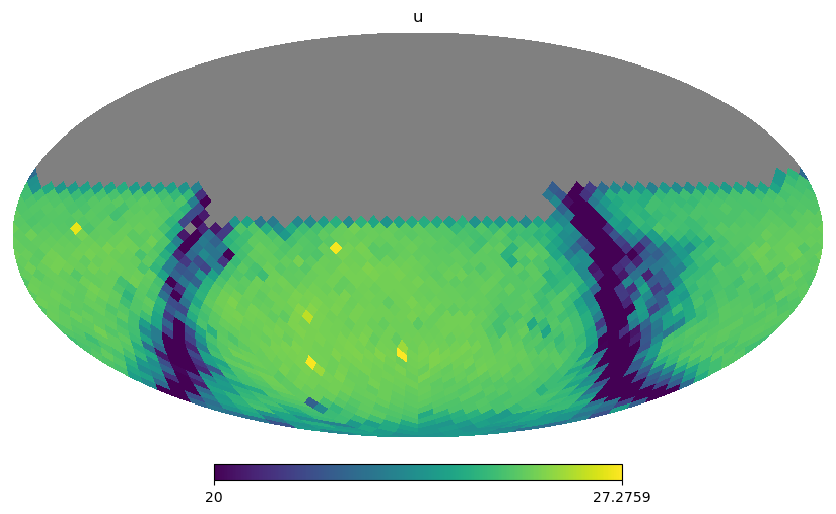

In [11]:
hp.mollview(bundle_dict['ExgalM5_u'].metric_values, min=20, title='u')

In [12]:
# ok, now let's try running high resolution on a DDF
from rubin_sim.utils import hpid2_ra_dec, angular_separation, ddf_locations

locations = ddf_locations()


In [13]:
# Here are the DDF locations. You will probably want to merge EDFS_a and b together as one
locations

{'ELAISS1': (9.45, -44.0),
 'XMM_LSS': (35.708333, -4.75),
 'ECDFS': (53.125, -28.1),
 'COSMOS': (150.1, 2.1819444444444445),
 'EDFS_a': (58.9, -49.315),
 'EDFS_b': (63.6, -47.6)}

In [14]:

nside=512
# Select only spots within radius of COSMOS
ra, dec = hpid2_ra_dec(nside, np.arange(hp.nside2npix(nside)))
DDF_name = 'COSMOS'
ddf_ra = locations[DDF_name][0]
ddf_dec = locations[DDF_name][1]

radius = 3.2  # Degrees
dist = angular_separation(ra, dec, ddf_ra, ddf_dec)
near = np.where(dist <= radius)[0]


slicer = maf.HealpixSubsetSlicer(nside, near, use_cache=False)
metric = ExgalCoadding()
sql = ''
# Little additions to change the default plots a bit
plot_funcs = [maf.HealpixSkyMap()]
plot_dict = {"visufunc": hp.gnomview, "rot": (ddf_ra, ddf_dec, 0),
            "xsize": 500}
# stack on a summary metric that takes a median
summary_stats = [maf.MedianMetric()]

bundle_list = [maf.MetricBundle(metric, slicer, sql, run_name=run_name,
                                summary_metrics=summary_stats,
                                plot_dict=plot_dict, plot_funcs=plot_funcs)]
bundle_dict = maf.make_bundles_dict_from_list(bundle_list)


Healpix slicer using NSIDE=512, approximate resolution 6.870973 arcminutes


/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/maps/dust_map.py:42: UserWarning: Slicer value of nside 512 different from map value 128, using slicer value
  warnings.warn(
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/plots/plot_handler.py:587: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn(


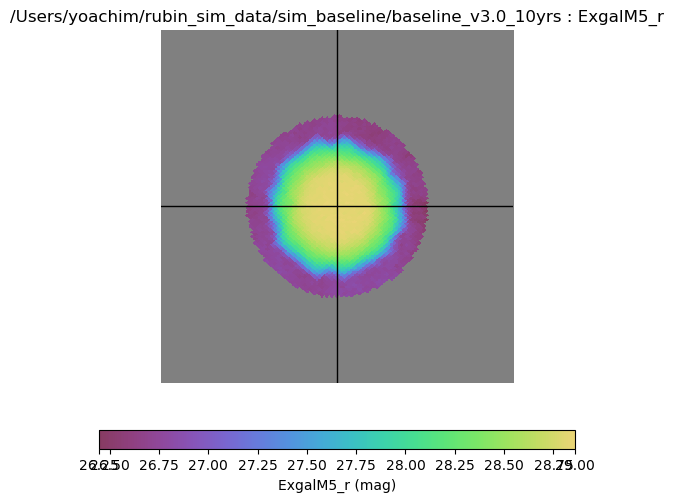

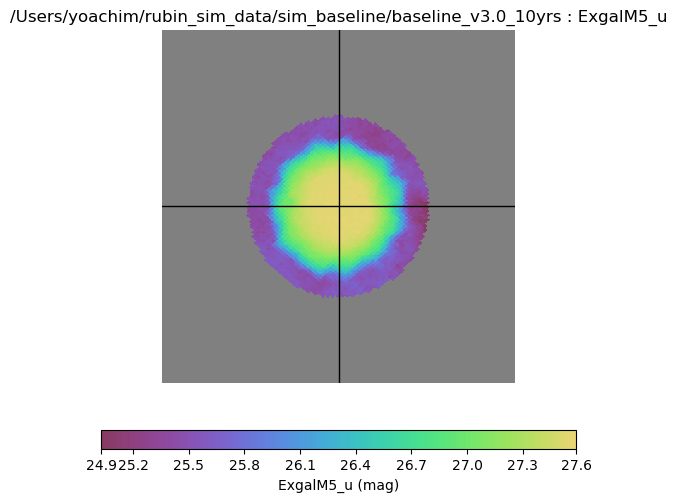

In [15]:
bg = maf.MetricBundleGroup(bundle_dict, filename, out_dir='temp',results_db=None)
bg.run_all()
bg.plot_all(closefigs=False)

In [16]:
for key in bundle_dict:
    print(key, bundle_dict[key].summary_values)

_Users_yoachim_rubin_sim_data_sim_baseline_baseline_v3_0_10yrs_ExgalM5_HEAL {}
ExgalM5_r {'Median': 27.583538918564038}
ExgalM5_u {'Median': 26.305286586344824}
